# **Project - Recommendation Systems: Movie Recommendation System**

## **Marks: 40**
---------------
## **Context**
---------------

Online streaming platforms like **Netflix** have plenty of movies in their repository and if we can build a **Recommendation System** to recommend **relevant movies** to users, based on their **historical interactions**, this would **improve customer satisfaction** and hence, it will also improve the revenue of the platform. The techniques that we will learn here will not only be limited to movies, it can be any item for which you want to build a recommendation system.

-----------------
## **Objective**
-----------------

In this project we will be building various recommendation systems: 
- Knowledge/Rank based recommendation system
- Similarity-Based Collaborative filtering
- Matrix Factorization Based Collaborative Filtering

we are going to use the **ratings** dataset. 

-----------------
## **Dataset**
-----------------

The **ratings** dataset contains the following attributes: 
- userId
- movieId
- rating
- timestamp

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this case study.

Let's start by mounting the Google drive on Colab.

In [1]:
# uncomment if you are using google colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [2]:
# Installing surprise library, only do it for first time
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3193652 sha256=b92709bbc50dd9f403deee8281ffae1d8400d54b25c21499aff8f2a7254e7458
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [3]:
# Used to ignore the warning given as output of the code
import warnings                                 
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np                              
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt     

# Slightly advanced library for data visualization            
import seaborn as sns                           

# A dictionary output that does not raise a key error
from collections import defaultdict             

# A performance metrics in surprise
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# For implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing cross validation
from surprise.model_selection import KFold

### **Loading the data**

In [4]:
#Import the dataset
rating = pd.read_csv('/content/drive/MyDrive/ratings.csv')

Let's check the **info** of the data

In [5]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


- There are **1,00,004 observations** and **4 columns** in the data
- All the columns are of **numeric data type**
- The data type of the timestamp column is int64 which is not correct. We can convert this to DateTime format but **we don't need timestamp for our analysis**. Hence, **we can drop this column**

In [6]:
# Dropping timestamp column
rating = rating.drop(['timestamp'], axis=1)

## **Question 1: Exploring the dataset (7 Marks)**

Let's explore the dataset and answer some basic data-related questions:

###**Q 1.1 Print the top 5 rows of the dataset (1 Mark)**

In [7]:
# Printing the top 5 rows of the dataset Hint: use .head()

# Remove _______and complete the code
rating.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


### **Q 1.2 Describe the distribution of ratings. (1 Mark)**



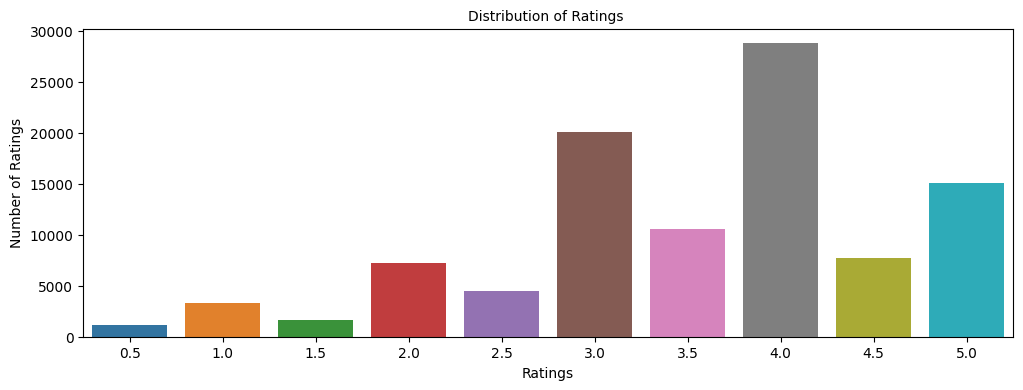

In [8]:
plt.figure(figsize = (12, 4))

# Remove _______and complete the code
sns.countplot(x="rating", data=rating)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

**Write your Answer here:______**

From the bar chart above, we can see that Rating 4.0 has the biggest number of ratings, which is close to 30,000.

Rating 3.0 and 5.0 have the second and third largest numbers of ratings, which are 20,000 and 15,000 respectively.

The number of ratings of Rating 3.5 is 10,000, making it the fourth one.

Interestingly, Ratings 2.0 and 4.5 share almost the same number of ratings, which is about 8,000.

Rating 0.5 has the smallest number of ratings.

### **Q 1.3 What is the total number of unique users and unique movies? (1 Mark)**


In [9]:
# Finding number of unique users
#remove _______ and complete the code
rating['userId'].nunique()

671

**Write your answer here:______**

There are 671 unique users in the dataset.

In [10]:
# Finding number of unique movies
# Remove _______ and complete the code

rating['movieId'].nunique()

9066

**Write your answer here:______**

There are 9066 unique movies in the dataset.

### **Q 1.4 Is there a movie in which the same user interacted with it more than once? (1 Mark)**

In [11]:
rating.groupby(['userId', 'movieId']).count()

rating
userId movieId        
1      31            1
       1029          1
       1061          1
       1129          1
       1172          1
...                ...
671    6268          1
       6269          1
       6365          1
       6385          1
       6565          1

[100004 rows x 1 columns]

In [12]:
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100004

**Write your Answer here:__________**

No. As the sum is equal to the total number of observations which implies that there is only interaction between a pair of items and a user.

### **Q 1.5 Which is the most interacted movie in the dataset? (1 Mark)**

In [13]:
# Remove _______ and complete the code
rating['movieId'].value_counts()

356       341
296       324
318       311
593       304
260       291
         ... 
98604       1
103659      1
104419      1
115927      1
6425        1
Name: movieId, Length: 9066, dtype: int64

**Write your Answer here:______**

The movie with movieId 356 is the most interacted movie in the dataset because its value count is 341 as shown above.

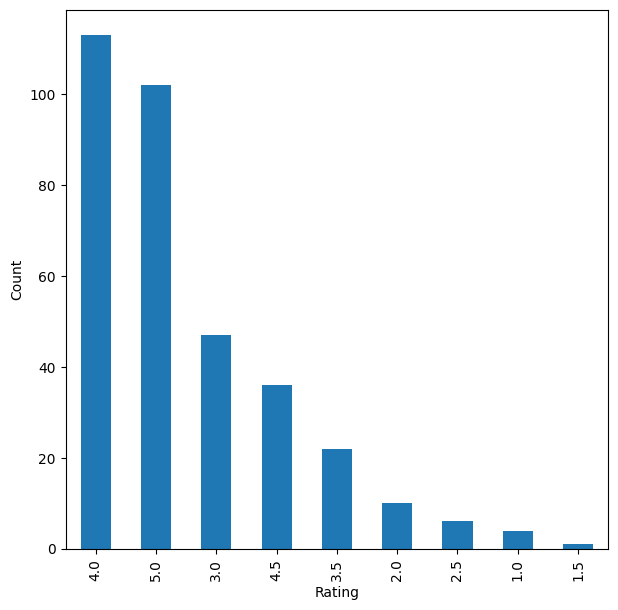

In [14]:
# Plotting distributions of ratings for 341 interactions with movieid 356 
plt.figure(figsize=(7,7))

rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

**Write your Answer here:______**

The bars of Rating 4.0 and 5.0 have the biggest counts and they dwarf the others in the bar chart, implying that this movie is liked by the majority of the users. It can be deduced that it is a great movie.

### **Q 1.6 Which user interacted the most with any movie in the dataset? (1 Mark)**

In [15]:
# Remove _______ and complete the code
rating['userId'].value_counts()

547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
296      20
289      20
249      20
221      20
1        20
Name: userId, Length: 671, dtype: int64

**Write your Answer here:_______**

The user with userId 547 has interacted the most with movies in the dataset because his/her value count is 2391.

### **Q 1.7 What is the distribution of the user-movie interactions in this dataset? (1 Mark)**

In [16]:
# Finding user-movie interactions distribution
count_interactions = rating.groupby('userId').count()['movieId']
count_interactions

userId
1       20
2       76
3       51
4      204
5      100
      ... 
667     68
668     20
669     37
670     31
671    115
Name: movieId, Length: 671, dtype: int64

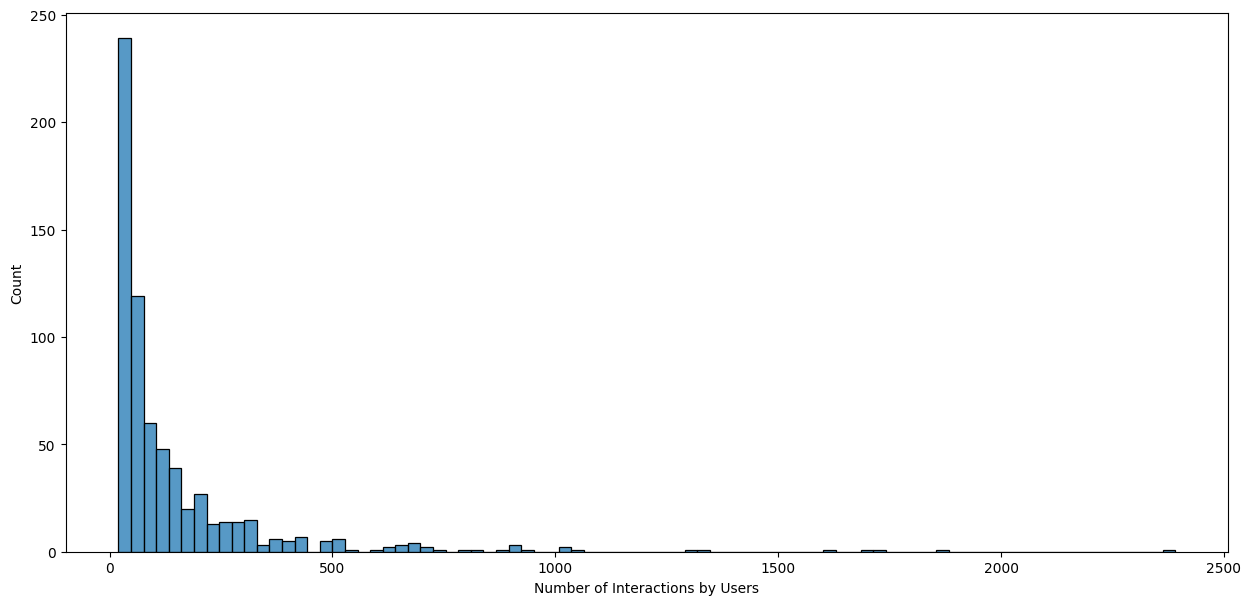

In [17]:
# Plotting user-movie interactions distribution

plt.figure(figsize=(15,7))
# Remove _______ and complete the code

sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

**Write your Answer here:__________**

The distribution is highly right-skewed, it means that most users have only rated a handful of movies so far. The number of interactions of most users is below 500.

#### As we have now explored the data, let's start building Recommendation systems

## **Question 2: Create Rank-Based Recommendation System (3 Marks)**

### **Model 1: Rank-Based Recommendation System**

Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have **cold start** problems. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend movies to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use rank-based recommendation system to recommend movies to the new user.

To build the rank-based recommendation system, we take **average** of all the ratings provided to each movie and then rank them based on their average rating.

In [18]:
# Remove _______ and complete the code

# Calculating average ratings
average_rating = rating.groupby('movieId').mean()['rating']

# Calculating the count of ratings
count_rating = rating.groupby('movieId').count()['rating']

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [19]:
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


Now, let's create a function to find the **top n movies** for a recommendation based on the average ratings of movies. We can also add a **threshold for a minimum number of interactions** for a movie to be considered for recommendation. 

In [20]:
def top_n_movies(data, n, min_interaction=100):
    
    #Finding movies with minimum number of interactions
    recommendations = data[data['rating_count'] >= min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get movies to recommend

#### **Recommending top 5 movies with 50 minimum interactions based on popularity**

In [21]:
# Remove _______ and complete the code
list(top_n_movies(final_rating, 5, 50))

[858, 318, 969, 913, 1221]

#### **Recommending top 5 movies with 100 minimum interactions based on popularity**

In [22]:
# Remove _______ and complete the code
list(top_n_movies(final_rating, 5, 100))

[858, 318, 1221, 50, 527]

#### **Recommending top 5 movies with 200 minimum interactions based on popularity**

In [23]:
# Remove _______ and complete the code
list(top_n_movies(final_rating, 5, 200))

[858, 318, 50, 527, 608]

Now that we have seen **how to apply the Rank-Based Recommendation System**, let's apply the **Collaborative Filtering Based Recommendation Systems**.

## **Model 2: User based Collaborative Filtering Recommendation System (7 Marks)**

![collaborative_filtering.PNG](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/collaborative_filtering.PNG)

In the above **interactions matrix**, out of users B and C, which user is most likely to interact with the movie, "The Terminal"?

In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example - 
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
</ol>

**Types of Collaborative Filtering**

- Similarity/Neighborhood based

 * User-User Similarity Based  
 * Item-Item similarity based

- Model based

#### **Building Similarity/Neighborhood based Collaborative Filtering**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/cosine.PNG)

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`**. Finally splitting the data into train and test set.

#### **Making the dataset into surprise dataset and splitting it into train and test set**

In [24]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#### **Build the first baseline similarity based recommendation system using cosine similarity and KNN**

In [25]:
# Remove _______ and complete the code
sim_options = {'name': 'cosine',
               'user_based': True}
               
# Defining Nearest neighbour algorithm
algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_user.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9925


0.9924509041520163

### **Q 3.1 What is the RMSE for baseline user based collaborative filtering recommendation system? (1 Mark)**

**Write your Answer here:______**

Based on the result shown above, the RMSE for baseline user is 0.9925.

### **Q 3.2 What is the Predicted  rating for an user with userId=4 and for movieId=10 and movieId=3? (1 Mark)**

Let's us now predict rating for an user with `userId=4` and for `movieId=10`

In [26]:
# Remove _______ and complete the code
algo_knn_user.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

**Write your Answer here:_______**

The predicted rating for an user with userId=4 is 3.62 by the model.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`

In [27]:
# Remove _______ and complete the code
algo_knn_user.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.20   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

**Write your Answer here:______**

The predicted rating is 3.20 is this case.

### **Improving user-user similarity based recommendation system by tuning its hyper-parameters**

Below we will be tuning hyper-parmeters for the `KNNBasic` algorithms. Let's try to understand different hyperparameters of KNNBasic algorithm - 

- **k** (int) – The (max) number of neighbors to take into account for aggregation (see this note). Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - pearson
    - pearson baseline
    
For more details please refer the official documentation https://surprise.readthedocs.io/en/stable/knn_inspired.html

### **Q 3.3 Perform hyperparameter tuning for the baseline user based collaborative filtering recommendation system and find the RMSE for tuned user based collaborative filtering recommendation system? (3 Marks)**

In [28]:
# Remove _______ and complete the code

# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}}

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9672501344007681
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters** as shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [29]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.969126,0.966546,0.966078,0.967250,0.001340,1,0.743807,0.742474,0.743150,0.743144,0.000544,1,0.152035,0.037774,3.537817,0.806791,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,0.996918,0.994053,0.995442,0.995471,0.001170,14,0.769864,0.767663,0.769680,0.769069,0.000997,11,0.527510,0.168413,3.778763,0.811788,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,0.970396,0.968997,0.967895,0.969096,0.001023,2,0.745710,0.745065,0.744549,0.745108,0.000475,2,0.118447,0.001064,3.126956,0.326113,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"
3,0.996927,0.994909,0.995957,0.995931,0.000824,15,0.770622,0.768926,0.769872,0.769807,0.000694,14,0.528696,0.181225,5.344371,0.916019,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': True}"
4,0.977501,0.975062,0.974601,0.975721,0.001273,7,0.751512,0.749912,0.750335,0.750586,0.000677,7,0.320096,0.040238,3.200526,0.209064,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': True}"


Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.



In [30]:
# Remove _______ and complete the code
sim_options = {'name': 'cosine',
               'user_based': True}

# Using the optimal similarity measure for user-user based collaborative filtering
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_user = KNNBasic(sim_options=sim_options, k=40, min_k=6,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_user.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9908


0.9907613369496804

**Write your Answer here:__________**

The RMSE for testset has reduced to 0.9908 from 0.9925.
The model has been slightly improved after hyperparameter tuning.

### **Q 3.4 What is the Predicted rating for an user with userId =4 and for movieId= 10 and movieId=3 using tuned user based collaborative filtering? (1 Mark)**

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model

In [31]:
# Remove _______ and complete the code
similarity_algo_optimized_user.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

**Write your Answer here:______**

The predicted rating for the user with userId=4 and for movideId=10 is 3.62.

Below we are predicting rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`, by using the optimized model as shown below - 

In [32]:
# Remove _______ and complete the code
similarity_algo_optimized_user.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.20   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

**Write your Answer here:______**

The predicted rating for the user with userId=4 and for movideId=3 is 3.20.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the `userId=4` based on the `msd` distance metric

In [33]:
similarity_algo_optimized_user.get_neighbors(4, k=5)

[357, 220, 590, 491, 647]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are - 

- data: a rating dataset
- user_id: an user id against which we want the recommendations
- top_n: the number of movies we want to recommend
- algo: the algorithm we want to use to predict the ratings

In [34]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has not interacted yet
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has not interacted yet
    for item_id in non_interacted_movies:
        
        # Predicting the ratings for those non interacted movie ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating movies for this user

#### **Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [35]:
#remove _______ and complete the code
recommendations = get_recommendations(rating,4,5,similarity_algo_optimized_user)

### **Q 3.5 Predict the top 5 movies for userId=4 with similarity based recommendation system (1 Mark)**

In [36]:
recommendations

[(98491, 4.832340578646058),
 (116, 4.753206589295344),
 (6669, 4.748048450384675),
 (1221, 4.662571141751736),
 (1192, 4.65824768595177)]

## **Model 3: Item based Collaborative Filtering Recommendation System (7 Marks)**

In [37]:
# Remove _______ and complete the code

# Definfing similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

# Defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0032


1.003221450633729

### **Q 4.1 What is the RMSE for baseline item based collaborative filtering recommendation system ?(1 Mark)**

**Write your Answer here:__________**

The RMSE for baseline item based collaborative filtering recommendation system is 1.0032.

Let's us now predict rating for an user with `userId=4` and for `movieId=10`

### **Q 4.2 What is the Predicted  rating for an user with userId =4 and for movieId= 10 and movieId=3? (1 Mark)**

In [38]:
# Remove _______ and complete the code
algo_knn_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.37   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.373794871885004, details={'actual_k': 40, 'was_impossible': False})

**Write your Answer here:__________**

The predicted rating for the user with userId=4 and for movieId=10 is 4.37.

Let's predict  the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`

In [39]:
# Remove _______ and complete the code
algo_knn_item.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 4.07   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=4.071601862880049, details={'actual_k': 40, 'was_impossible': False})

**Write your Answer here:__________**

The predicted rating for the user with userId=4 and for movieId=3 is 4.07.

### **Q 4.3 Perform hyperparameter tuning for the baseline item based collaborative filtering recommendation system and find the RMSE for tuned item based collaborative filtering recommendation system? (3 Marks)**

In [40]:
# Remove _______ and complete the code

# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30,40], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}}

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9401952144327224
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above**

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [41]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,0.949874,0.952411,0.948989,0.950424,0.001450,8,0.733084,0.734332,0.732743,0.733387,0.000683,7,6.308456,1.969322,13.312587,0.179712,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,1.013752,1.015975,1.014041,1.014589,0.000987,17,0.788997,0.791665,0.790149,0.790271,0.001093,16,6.743622,0.785345,12.940579,0.678198,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,0.950168,0.951716,0.949178,0.950354,0.001044,7,0.733456,0.734052,0.732980,0.733496,0.000438,8,4.748707,0.076486,12.633051,0.352936,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': False}"
3,1.013924,1.015608,1.014216,1.014583,0.000735,16,0.789241,0.791496,0.790327,0.790355,0.000921,17,5.864543,0.035645,12.739942,0.169099,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'cosine', 'user_based': False}"
4,0.950176,0.951825,0.949347,0.950449,0.001030,9,0.733492,0.734253,0.733224,0.733657,0.000436,9,3.286759,0.101404,12.989368,0.219767,"{'k': 20, 'min_k': 9, 'sim_options': {'name': ...",20,9,"{'name': 'msd', 'user_based': False}"


Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

In [42]:
# Remove _______ and complete the code
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=30, min_k=6,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9465


0.9465120620317036

**Write your Answer here:__________**

The RMSE for testset has reduced to 0.9465 from 1.0032. The model has been slightly improved after hyperparameter tuning.

### **Q 4.4 What is the Predicted rating for an item with userId =4 and for movieId= 10 and movieId=3 using tuned item based collaborative filtering? (1 Mark)**

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model as shown below

In [43]:
# Remove _______ and complete the code
similarity_algo_optimized_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.30   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.298279280483517, details={'actual_k': 30, 'was_impossible': False})

**Write your Answer here:___________**

The predicted rating for an item with userId=4 and for movieId=10 is 4.30.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`, by using the optimized model:

In [44]:
# Remove _______ and complete the code
similarity_algo_optimized_item.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.86   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.859023126306401, details={'actual_k': 30, 'was_impossible': False})

**Write your Answer here:________**

The predicted rating for an item with userId=4 and for movieId=3 is 3.86.

### **Identifying similar items to a given item (nearest neighbors)**
We can also find out the similar items to a given item or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar items to the `movieId=3` based on the `msd` distance metric

In [45]:
# Remove _______ and complete the code
similarity_algo_optimized_item.get_neighbors(3, k=5)

[31, 37, 42, 48, 73]

#### **Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [46]:
# Remove _______ and complete the code
recommendations = get_recommendations(rating, 4, 5, similarity_algo_optimized_item)

### **Q 4.5 Predict the top 5 movies for userId=4 with similarity based recommendation system (1 Mark)**

In [47]:
recommendations

[(84, 5), (1040, 5), (2481, 5), (3515, 5), (4521, 5)]

## **Model 4: Based Collaborative Filtering - Matrix Factorization using SVD (7 Marks)**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

**Latent Features:** The features that are not present in the empirical data but can be inferred from the data. For example:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF3.PNG)

Now if we notice the above movies closely:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF4.PNG)

Here **Action**, **Romance**, **Suspense** and **Comedy** are latent features of the corresponding movies. Similarly, we can compute the latent features for users as shown below:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF5.PNG)



### **Singular Value Decomposition (SVD)**

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

First we need to convert the below movie-rating dataset:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF3.PNG)

into an user-item matrix as shown below:

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF6.PNG)

We have already done this above while computing cosine similarities.

**SVD decomposes this above matrix into three separate matrices:**
- U matrix
- Sigma matrix
- V transpose matrix

#### **U-matrix**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF7.PNG)

the above matrix is a n x k matrix, where:
- n is number of users
- k is number of latent features

#### **Sigma-matrix**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF8.PNG)

the above matrix is a k x k matrix, where:
- k is number of latent features
- Each diagonal entry is the singular value of the original interaction matrix

#### **V-transpose matrix**

![test_image](https://raw.githubusercontent.com/GL-ACADOPS/RS-IMAGES/main/CF9.PNG)

the above matrix is a kxn matrix, where:
- k is the number of latent features
- n is the number of items

### **Build a baseline matrix factorization recommendation system**

In [48]:
# Remove _______ and complete the code

# Using SVD matrix factorization
algo_svd = SVD()

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)

# Computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9029


0.9028533052404858

### **Q 5.1 What is the RMSE for baseline SVD based collaborative filtering recommendation system? (1 Mark)**

**Write your Answer here:___________**

The RMSE for baseline SVD based collaborative filtering recommendation system is 0.9013.

### **Q 5.2 What is the Predicted  rating for an user with userId =4 and for movieId= 10 and movieId=3? (1 Mark)**

Let's us now predict rating for an user with `userId=4` and for `movieId=10`

In [49]:
# Remove _______ and complete the code
algo_svd.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.87   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.8660474576333703, details={'was_impossible': False})

**Write your Answer here:______**

The predicted rating for the user with userId=4 and for movieId=10 is 3.87.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`:

In [50]:
# Remove _______ and complete the code
algo_svd.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.49   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.4900077311645776, details={'was_impossible': False})

**Write your Answer here:_____**

The predicted rating for the user with userId=4 and for movieId=3 is 3.49.

### **Improving matrix factorization based recommendation system by tuning its hyper-parameters**

In SVD, rating is predicted as - 

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward **stochastic gradient descent**:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

There are many hyperparameters to tune in this algorithm, you can find a full list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

Below we will be tuning only three hyperparameters -
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

### **Q 5.3 Perform hyperparameter tuning for the baseline SVD based collaborative filtering recommendation system and find the RMSE for tuned SVD based collaborative filtering recommendation system? (3 Marks)**

In [51]:
# Remove _______ and complete the code

# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8933705905241139
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


Once the **grid search** is complete, we can get the **optimal values** for each of those hyperparameters, as shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [52]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.947715,0.943114,0.939073,0.943301,0.003530,25,0.742239,0.738280,0.734354,0.738291,0.003219,25,0.826546,0.015919,0.460143,0.039196,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,0.951946,0.947424,0.943942,0.947771,0.003277,26,0.746669,0.743517,0.739895,0.743360,0.002768,26,0.865336,0.011443,0.457094,0.031311,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,0.957228,0.952933,0.948907,0.953023,0.003398,27,0.752503,0.749578,0.745701,0.749261,0.002786,27,0.883257,0.081681,0.461836,0.053636,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6
3,0.911571,0.904802,0.903476,0.906616,0.003545,11,0.706227,0.701207,0.699253,0.702229,0.002937,9,1.320592,0.210192,0.846389,0.111731,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}",10,0.005,0.2
4,0.918767,0.912281,0.910721,0.913923,0.003484,15,0.713826,0.709209,0.707274,0.710103,0.002749,15,1.253730,0.342302,0.419520,0.004527,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [53]:
# Remove _______ and complete the code

# Building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2)

# Training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# Computing RMSE
accuracy.rmse(predictions)

RMSE: 0.8967


0.8967456427358368

### **Q 5.4 What is the Predicted rating for an user with userId =4 and for movieId= 10 and movieId=3 using SVD based collaborative filtering? (1 Mark)**

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model

In [54]:
# Remove _______ and complete the code
svd_algo_optimized.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.99   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.986539749638199, details={'was_impossible': False})

**Write your Answer here:_________**

The predicted ratings for the user with userId=4 and for movieId=10 & 3 are 3.99 and 3.63 respectively.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`:

In [55]:
# Remove _______ and complete the code
svd_algo_optimized.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.63   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.630864289880199, details={'was_impossible': False})

### **Q 5.5 Predict the top 5 movies for userId=4 with SVD based recommendation system?(1 Mark)**

In [56]:
# Remove _______ and complete the code
get_recommendations(rating, 4, 5, svd_algo_optimized)

[(926, 4.944530419112846),
 (1192, 4.882615834386502),
 (1217, 4.8676803206344275),
 (3035, 4.862569139793116),
 (1948, 4.8514021088210395)]

### **Predicting ratings for already interacted movies** 

Below we are comparing the rating predictions of users for those movies which has been already watched by an user. This will help us to understand how well are predictions are as compared to the actual ratings provided by users

In [57]:
def predict_already_interacted_ratings(data, user_id, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has interacted already
    interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has interacted already
    for item_id in interacted_movies:
        
        # Extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
        
        # Predicting the ratings for those non interacted movie ids by this user
        predicted_rating = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['movieId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating movies for this user

Here we are comparing the predicted ratings by `similarity based recommendation` system against actual ratings for `userId=7`

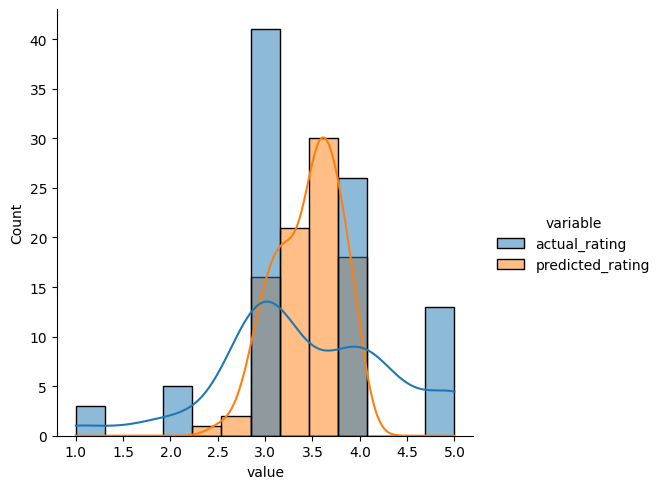

In [58]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, similarity_algo_optimized_item)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

**Write your Answer here:__________**

The distribution of the actual rating is more sparse than that of the predicted rating.
The distribution of the predicted rating is more centralized at the value 3.5.
Most of the bins of the predicted rating are also at the value 3.5, which kind of makes sense if we compared it to the distribution of ratings in question 1.2.

Below we are comparing the predicted ratings by `matrix factorization based recommendation` system against actual ratings for `userId=7`

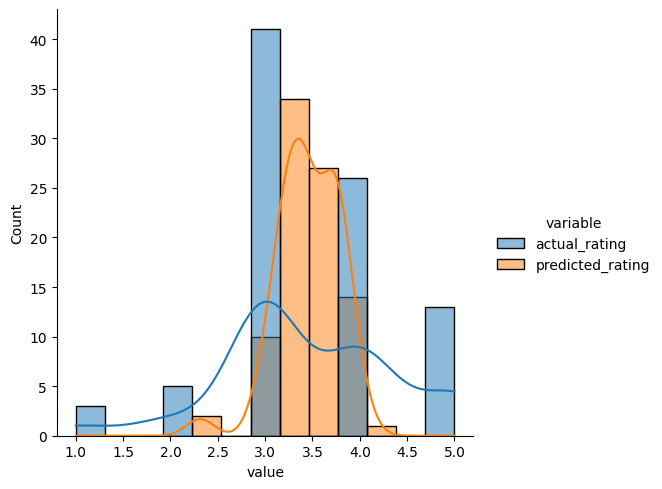

In [59]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, svd_algo_optimized)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

In [60]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

## **Precision and Recall @ k**

RMSE is not the only metric we can use here. We can also examine two fundamental measures, precision and recall. We also add a parameter k which is helpful in understanding problems with multiple rating outputs.

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. Value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  

**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**Recall** - It is the **fraction of actually relevant items that are recommended to the user** i.e. if out of 10 relevant movies, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision** - It is the **fraction of recommended items that are relevant actually** i.e. if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

See the Precision and Recall @ k section of your notebook and follow the instructions to compute various precision/recall values at various values of k.

To know more about precision recall in Recommendation systems refer to these links : 

https://surprise.readthedocs.io/en/stable/FAQ.html

https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54

### **Question6: Compute the precision and recall, for each of the 6 models, at k = 5 and 10. This is 6 x 2 = 12 numerical values? (4 marks)**

In [61]:
# Function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls



In [62]:
# A basic cross-validation iterator.
kf = KFold(n_splits=5)

# Make list of k values
K = [5, 10]

# Remove _______ and complete the code
# Make list of models
models = [algo_knn_user, similarity_algo_optimized_user,algo_knn_item,similarity_algo_optimized_item, algo_svd, svd_algo_optimized]

for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.766
-----> Recall:  0.406
> k=5, model=KNNBasic
-----> Precision:  0.771
-----> Recall:  0.419
> k=5, model=KNNBasic
-----> Precision:  0.612
-----> Recall:  0.327
> k=5, model=KNNBasic
-----> Precision:  0.682
-----> Recall:  0.357
> k=5, model=SVD
-----> Precision:  0.754
-----> Recall:  0.385
> k=5, model=SVD
-----> Precision:  0.75
-----> Recall:  0.386
> k=10, model=KNNBasic
-----> Precision:  0.749
-----> Recall:  0.549
> k=10, model=KNNBasic
-----> Precision:  0.747
-----> Recall:  0.561
> k=10, model=KNNBasic
-----> Precision:  0.6
-----> Recall:  0.477
> k=10, model=KNNBasic
-----> Precision:  0.662
-----> Recall:  0.503
> k=10, model=SVD
-----> Precision:  0.735
-----> Recall:  0.519
> k=10, model=SVD
-----> Precision:  0.731
-----> Recall:  0.521


### **Question 7 ( 5 Marks)**
**7.1 Compare the results from the base line user-user and item-item based models.**

**7.2 How do these baseline models compare to each other with respect to the tuned user-user and item-item models?**

**7.3 The matrix factorization model is different from the collaborative filtering models. Briefly describe this difference. Also, compare the RMSE and precision recall for the models.**

**7.4 Does it improve? Can you offer any reasoning as to why that might be?**

**Write your Answer here:__________**

User-based and Item-based Collaborative Models have nearly same. User based RMSE value is 0.9925 while the "Item based" model's RMSE is 1.0032. Clearly, tuned Collaborative Filtering Models have performed better than baseline model and the item based tuned model is performing better and have RMSE of 0.9465.

The Collaborative Models use the user-item-ratings data to find similarities and make predictions rather than just predicting a random rating based on the distribution of the data. This could a reason why the Collaborative filtering performed well.

Collaborative Filtering searches for neighbours based on similarity of item (example) preferences and recommend items that those neighbours interacted while Matrix factorization works by decomposing the user-item matrix into the product of two lower dimensionality rectangular matrices.

RMSE for Matrix Factorization (0.8967) is better than the Collaborative Filtering Models (~1.00).

Tuning SVD matrix factorization model is not improving the base line SVD much.

Matrix Factorization has lower RMSE due to the reason that it assumes that both items and users are present in some low dimensional space describing their properties and recommend an item based on its proximity to the user in the latent space. Implying it accounts for latent factors as well.


### **Conclusions**

In this case study, we saw three different ways of building recommendation systems: 
- rank-based using averages
- similarity-based collaborative filtering
- model-based (matrix factorization) collaborative filtering

We also understood advantages/disadvantages of these recommendation systems and when to use which kind of recommendation systems. Once we build these recommendation systems, we can use **A/B Testing** to measure the effectiveness of these systems.

Here is an article explaining how [Amazon use **A/B Testing**](https://aws.amazon.com/blogs/machine-learning/using-a-b-testing-to-measure-the-efficacy-of-recommendations-generated-by-amazon-personalize/) to measure effectiveness of its recommendation systems.